<a href="https://colab.research.google.com/github/Asiwaju887/Data-Analytics/blob/main/Deep%20Learning%20on%20Dublin%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from math import sqrt
from matplotlib import pyplot
import numpy

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


### **LSTM section**

In [4]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  # simple early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose= 1)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
  
  model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc], validation_split=0.3)
  saved_model = load_model('best_model.h5')
  
  return saved_model
  
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



In [5]:

# load dataset
cwd = read_csv('/content/drive/MyDrive/Ireland_DAV_Data.csv', low_memory=False)

series = cwd['temp']

SyntaxError: ignored

In [ ]:



# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# Split data into training (80%) and test (20%)
nrow = round(0.7*series.shape[0])
train, test = supervised_values[0:nrow], supervised_values[(nrow+1):]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [ ]:

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

In [ ]:
# evaluate the model
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
trainX = X.reshape(X.shape[0], 1, X.shape[1])
trainy = y 

train_pred = lstm_model.predict(trainX, batch_size=1)
train_mse = mean_squared_error(trainy, train_pred)

X, y = test_scaled[:, 0:-1], test_scaled[:, -1]
testX = X.reshape(X.shape[0], 1, X.shape[1])
testy = y

test_pred = lstm_model.predict(testX, batch_size=1)
test_mse = mean_squared_error(testy, test_pred)

print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

In [ ]:


# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
#  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [ ]:

# report performance
rmse = sqrt(mean_squared_error(raw_values[(nrow+2):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
£pyplot.figure(figsize=(20,12))
pyplot.plot(raw_values[(nrow+1):])
pyplot.plot(predictions)
pyplot.show()

In [ ]:
from sklearn.metrics import r2_score
rscore = sqrt(r2_score(raw_values[(nrow+2):], predictions))
print('Test R2: %.3f' % rscore)

### **GRU section**

In [6]:
# fit an LSTM network to training data
def fit_gru(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  
  model = Sequential()
  model.add(GRU(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  # simple early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose= 1)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
  
  model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc], validation_split=0.3)
  saved_model = load_model('best_model.h5')
  
  return saved_model
  
# make a one-step forecast
def forecast_gru(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [7]:
# load dataset
cwd = read_csv('/content/drive/MyDrive/Ireland_DAV_Data.csv', low_memory=False)
series = cwd['temp']

In [8]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# Split data into training (80%) and test (20%)
nrow = round(0.7*series.shape[0])
train, test = supervised_values[0:nrow], supervised_values[(nrow+1):]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [9]:
# fit the model
gru_model = fit_gru(train_scaled, 1, 100, 6)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
gru_model.predict(train_reshaped, batch_size=1)


Epoch 1/100
129560/129560 [==============================] - 257s 2ms/step - loss: 0.0099 - val_loss: 0.0124

Epoch 00001: saving model to best_model.h5
Epoch 2/100
129560/129560 [==============================] - 273s 2ms/step - loss: 0.0096 - val_loss: 0.0979

Epoch 00002: saving model to best_model.h5
Epoch 3/100
129560/129560 [==============================] - 279s 2ms/step - loss: 0.0102 - val_loss: 0.5485

Epoch 00003: saving model to best_model.h5
Epoch 4/100
129560/129560 [==============================] - 241s 2ms/step - loss: 0.0117 - val_loss: 0.0868

Epoch 00004: saving model to best_model.h5
Epoch 5/100
129560/129560 [==============================] - 235s 2ms/step - loss: 0.0103 - val_loss: 0.0131

Epoch 00005: saving model to best_model.h5
Epoch 6/100
129560/129560 [==============================] - 283s 2ms/step - loss: 0.0103 - val_loss: 0.0131

Epoch 00006: saving model to best_model.h5
Epoch 7/100
129560/129560 [==============================] - 279s 2ms/step - loss:

array([[0.6036047 ],
       [1.2589816 ],
       [1.3998802 ],
       ...,
       [0.02353883],
       [0.02971619],
       [0.01970559]], dtype=float32)

In [10]:
# evaluate the model
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
trainX = X.reshape(X.shape[0], 1, X.shape[1])
trainy = y 

train_pred = gru_model.predict(trainX, batch_size=1)
train_mse = mean_squared_error(trainy, train_pred)

X, y = test_scaled[:, 0:-1], test_scaled[:, -1]
testX = X.reshape(X.shape[0], 1, X.shape[1])
testy = y

test_pred = gru_model.predict(testX, batch_size=1)
test_mse = mean_squared_error(testy, test_pred)

print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.012, Test: 0.013


In [11]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_gru(gru_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
#  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Test RMSE: 0.863


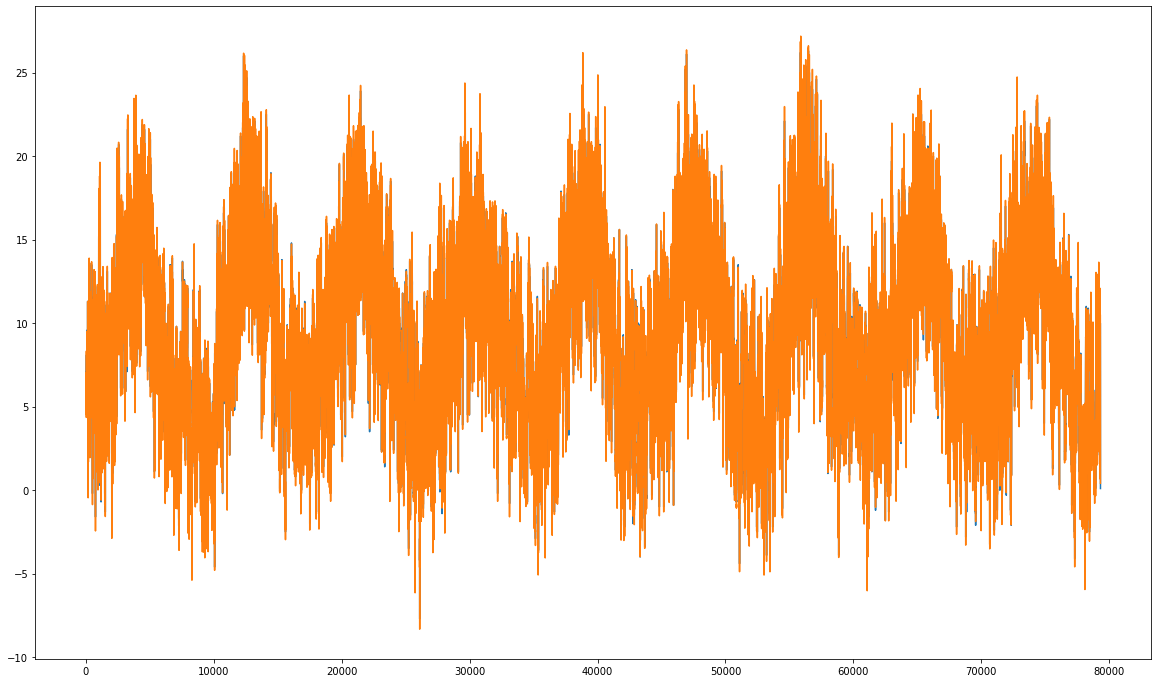

In [12]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[(nrow+2):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.figure(figsize=(20,12))
pyplot.plot(raw_values[(nrow+1):])
pyplot.plot(predictions)
pyplot.show()

In [13]:
from sklearn.metrics import r2_score
rscore = sqrt(r2_score(raw_values[(nrow+2):], predictions))
print('Test R2: %.3f' % rscore)

Test R2: 0.985
